In [1]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import re

In [2]:
import wget
import seaborn as sns

# Import Data

In [ ]:
# Download the Data with wget

wget.download ('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip')

In [4]:
# Unzip the file and extract data 

import zipfile
zip_ref = zipfile.ZipFile("bank-additional.zip", 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

In [5]:
# Read data and show it 

data = pd.read_csv('./bank-additional/bank-additional-full.csv', sep=';')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# Show the data columns 

data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Let's talk about the data. At a high level, we can see:
   
    * We have a little over 40K customer records, and 20 features for each customer
    * The features are mixed; some numeric, some categorical
    * The data appears to be sorted, at least by time and contact, maybe more

Specifics on each of the features:

Demographics:

    * age: Customer's age (numeric)
    * job: Type of job (categorical: 'admin.', 'services', ...)
    * marital: Marital status (categorical: 'married', 'single', ...)
    * education: Level of education (categorical: 'basic.4y', 'high.school', ...)

Past customer events:

    * default: Has credit in default? (categorical: 'no', 'unknown', ...)
    * housing: Has housing loan? (categorical: 'no', 'yes', ...)
    * loan: Has personal loan? (categorical: 'no', 'yes', ...)

Past direct marketing contacts:

    * contact: Contact communication type (categorical: 'cellular', 'telephone', ...)
    * month: Last contact month of year (categorical: 'may', 'nov', ...)
    * day_of_week: Last contact day of the week (categorical: 'mon', 'fri', ...)
    * duration: Last contact duration, in seconds (numeric). Important note: If duration = 0 then y = 'no'.

Campaign information:

    * campaign: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
    * pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
    * previous: Number of contacts performed before this campaign and for this client (numeric)
    * poutcome: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)

External environment factors:

    * emp.var.rate: Employment variation rate - quarterly indicator (numeric)
    * cons.price.idx: Consumer price index - monthly indicator (numeric)
    * cons.conf.idx: Consumer confidence index - monthly indicator (numeric)
    * euribor3m: Euribor 3 month rate - daily indicator (numeric)
    * nr.employed: Number of employees - quarterly indicator (numeric)

Target variable:

    * y: Has the client subscribed a term deposit? (binary: 'yes','no')



# Explore Data 

In [7]:
for columns in data.columns:
    display(pd.crosstab(index = data[columns] , columns = "% observations", normalize='columns') * 100)

col_0,% observations
age,
17,0.012139
18,0.067981
19,0.101971
20,0.157813
21,0.247645
22,0.332621
23,0.548704
24,1.124114
25,1.451879


col_0,% observations
job,
admin.,25.303486
blue-collar,22.467709
entrepreneur,3.535010
housemaid,2.573565
management,7.099155
retired,4.175974
self-employed,3.450034
services,9.636302
student,2.124405


col_0,% observations
marital,
divorced,11.197436
married,60.522482
single,28.085850
unknown,0.194231


col_0,% observations
education,
basic.4y,10.138875
basic.6y,5.564728
basic.9y,14.676605
high.school,23.101389
illiterate,0.043702
professional.course,12.729436
university.degree,29.542585
unknown,4.202680


col_0,% observations
default,
no,79.120132
unknown,20.872584
yes,0.007284


col_0,% observations
housing,
no,45.212198
unknown,2.403613
yes,52.384190


col_0,% observations
loan,
no,82.426920
unknown,2.403613
yes,15.169467


col_0,% observations
contact,
cellular,63.474798
telephone,36.525202


col_0,% observations
month,
apr,6.390211
aug,14.999514
dec,0.441876
jul,17.417694
jun,12.911528
mar,1.325629
may,33.429640
nov,9.956784
oct,1.743226


col_0,% observations
day_of_week,
fri,19.003108
mon,20.671069
thu,20.935709
tue,19.641643
wed,19.748470


col_0,% observations
duration,
0,0.009712
1,0.007284
2,0.002428
3,0.007284
4,0.029135
5,0.072837
6,0.089832
7,0.131106
8,0.167525


col_0,% observations
campaign,
1,42.832864
2,25.662814
3,12.967369
4,6.436341
5,3.882199
6,2.376906
7,1.527144
8,0.971157
9,0.687093


col_0,% observations
pdays,
0,0.036418
1,0.063125
2,0.148101
3,1.065844
4,0.286491
5,0.111683
6,1.000291
7,0.145673
8,0.043702


col_0,% observations
previous,
0,86.343110
1,11.073614
2,1.830630
3,0.524425
4,0.169952
5,0.043702
6,0.012139
7,0.002428


col_0,% observations
poutcome,
failure,10.323395
nonexistent,86.343110
success,3.333495


col_0,% observations
emp.var.rate,
-3.4,2.600272
-3.0,0.417597
-2.9,4.037584
-1.8,22.297757
-1.7,1.876760
-1.1,1.541711
-0.2,0.024279
-0.1,8.941925
1.1,18.847723


col_0,% observations
cons.price.idx,
92.201,1.869477
92.379,0.648247
92.431,1.085268
92.469,0.432165
92.649,0.866757
92.713,0.417597
92.756,0.024279
92.843,0.684665
92.893,14.067204


col_0,% observations
cons.conf.idx,
-50.8,0.310770
-50.0,0.684665
-49.5,0.495290
-47.1,5.967758
-46.2,14.067204
-45.9,0.024279
-42.7,16.230455
-42.0,8.779256
-41.8,10.619598


col_0,% observations
euribor3m,
0.634,0.019423
0.635,0.104399
0.636,0.033990
0.637,0.014567
0.638,0.016995
0.639,0.038846
0.640,0.024279
0.642,0.084976
0.643,0.055842


col_0,% observations
nr.employed,
4963.6,1.541711
4991.6,1.876760
5008.7,1.578130
5017.5,2.600272
5023.5,0.417597
5076.2,4.037584
5099.1,20.719627
5176.3,0.024279
5191.0,18.847723


col_0,% observations
y,
no,88.734583
yes,11.265417


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


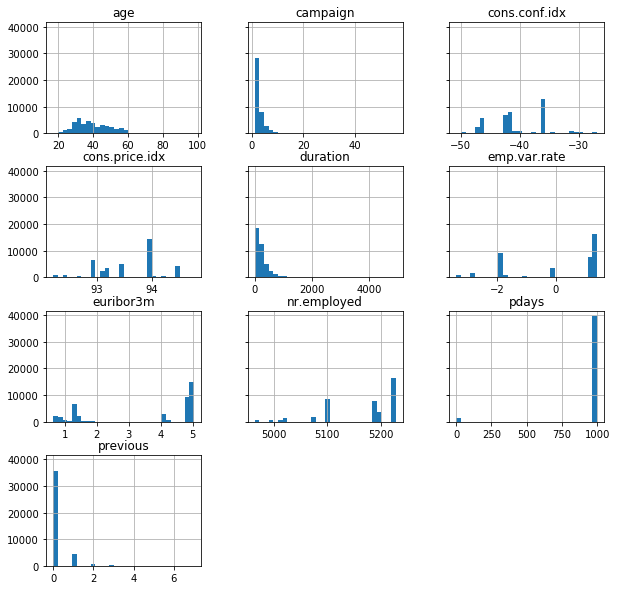

In [8]:
# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

In [9]:
# Show data Description
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


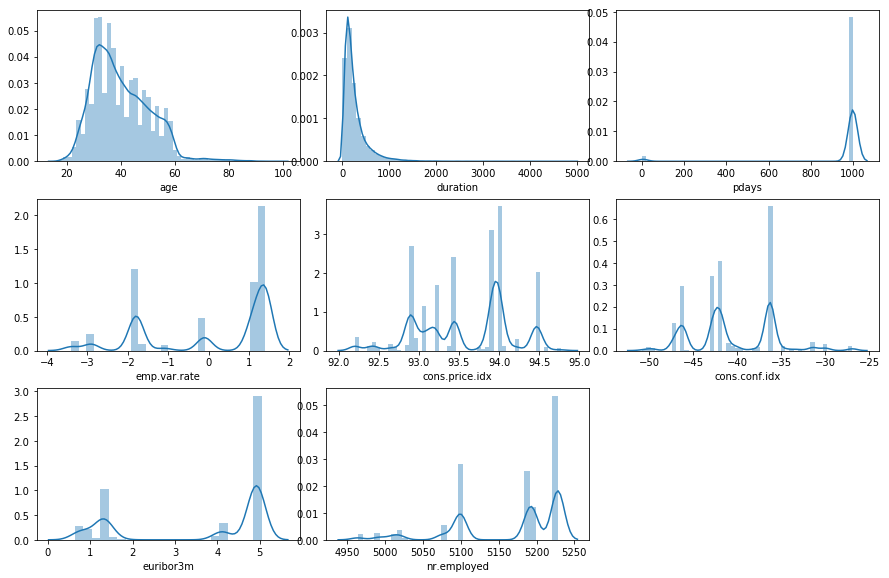

In [10]:
# Use subplot to show the numeric features
n = 331
for columns in ['age', 'duration','pdays', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']:
    plt.subplot(n)
    sns.distplot(data[columns])
    n = n+1
    plt.subplots_adjust(top=1.92, bottom=0.08, left=0.00, right=1.95, hspace=0.25,
                    wspace=0.1)

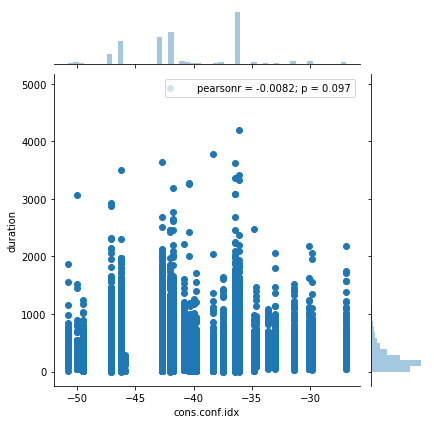

In [11]:
# Show correlation between price index and duration
sns.jointplot(x="cons.conf.idx", y="duration", data=data);

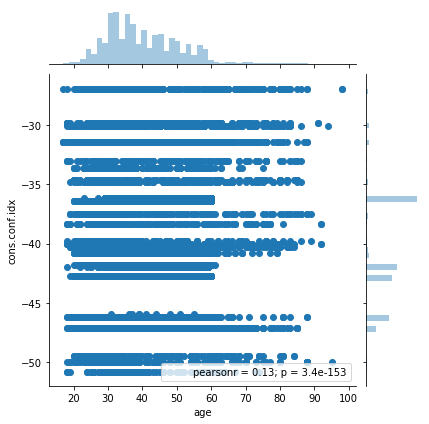

In [12]:
# Show correlation between price index and age
sns.jointplot(x="age", y="cons.conf.idx", data=data);

In [13]:
# Next, let's look at how our features relate to the target that we are attempting to predict.
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))



y,no,yes
job,,
admin.,0.248167,0.291379
blue-collar,0.235745,0.137500
entrepreneur,0.036445,0.026724
housemaid,0.026103,0.022845
management,0.071030,0.070690
retired,0.035187,0.093534
self-employed,0.034804,0.032112
services,0.099759,0.069612
student,0.016417,0.059267


y,no,yes
marital,,
divorced,0.113166,0.102586
married,0.612783,0.545690
single,0.272190,0.349138
unknown,0.001861,0.002586


y,no,yes
education,,
basic.4y,0.102550,0.092241
basic.6y,0.057568,0.040517
basic.9y,0.152457,0.101940
high.school,0.232133,0.222198
illiterate,0.000383,0.000862
professional.course,0.127175,0.128233
university.degree,0.287239,0.359914
unknown,0.040495,0.054095


y,no,yes
default,,
no,0.776814,0.904526
unknown,0.223104,0.095474
yes,0.000082,0.000000


y,no,yes
housing,,
no,0.454088,0.436638
unknown,0.024160,0.023060
yes,0.521752,0.540302


y,no,yes
loan,,
no,0.823574,0.829741
unknown,0.024160,0.023060
yes,0.152266,0.147198


y,no,yes
contact,,
cellular,0.60991,0.830388
telephone,0.39009,0.169612


y,no,yes
month,,
apr,0.057267,0.116164
aug,0.151116,0.141164
dec,0.002545,0.019181
jul,0.178532,0.139871
jun,0.130212,0.120474
mar,0.007388,0.059483
may,0.352495,0.190948
nov,0.100826,0.089655
oct,0.011027,0.067888


y,no,yes
day_of_week,,
fri,0.191009,0.182328
mon,0.209779,0.182543
thu,0.207344,0.225216
tue,0.195277,0.205388
wed,0.196591,0.204526


y,no,yes
poutcome,,
failure,0.099787,0.130388
nonexistent,0.887107,0.676940
success,0.013106,0.192672


age


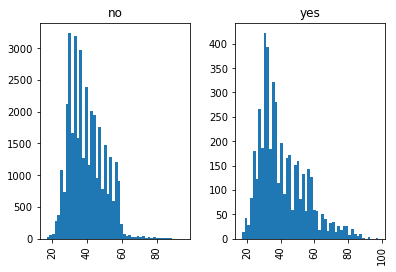

duration


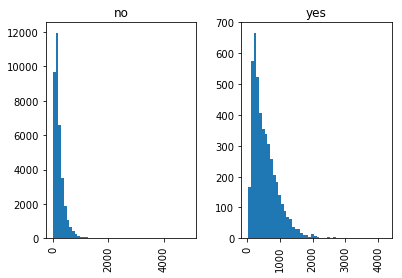

campaign


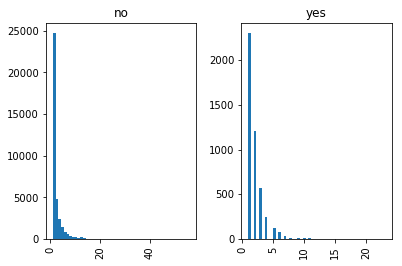

pdays


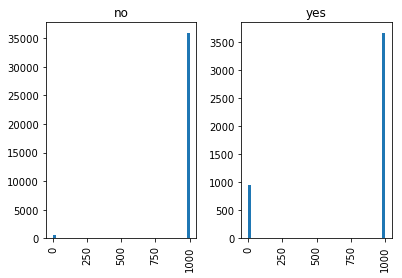

previous


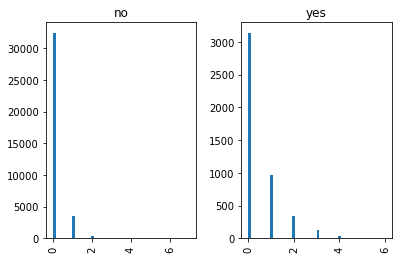

emp.var.rate


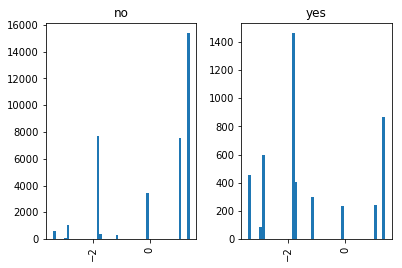

cons.price.idx


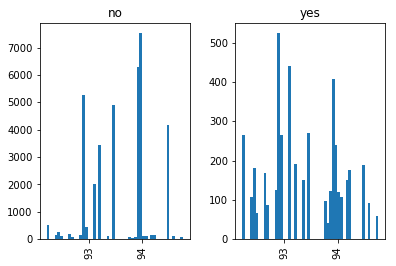

cons.conf.idx


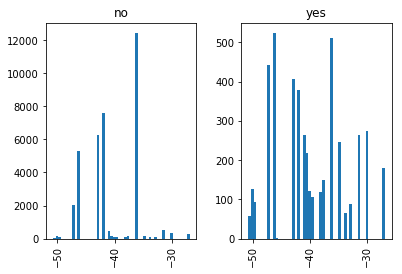

euribor3m


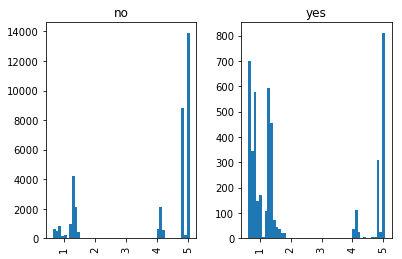

nr.employed


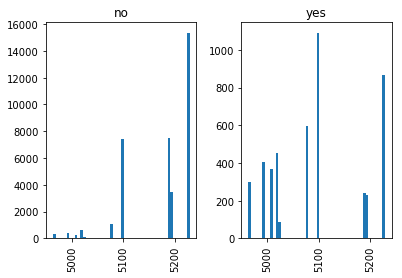

In [14]:
# show the plots 
for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=50)
    plt.show()

# Prepare Data 

Cleaning up data is part of nearly every machine learning project. It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process. 
Several common techniques include:

Handling missing values: Some machine learning algorithms are capable of handling missing values, but most would rather not. Options include:
    
    * Removing observations with missing values: This works well if only a very small fraction of observations have incomplete information.
    * Removing features with missing values: This works well if there are a small number of features which have a large number of missing values.
    
    * Imputing missing values: Entire books have been written on this topic, but common choices are replacing the missing value with the mode or mean of that column's non-missing values.
    
    * Converting categorical to numeric: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.
    
    *Oddly distributed data: Although for non-linear models like Gradient Boosted Trees, this has very limited implications, parametric models like regression can produce wildly inaccurate estimates when fed highly skewed data. In some cases, simply taking the natural log of the features is sufficient to produce more normally distributed data. In others, bucketing values into discrete ranges is helpful. These buckets can then be treated as categorical variables and included in the model when one hot encoded.
    
    *Handling more complicated data types: Mainpulating images, text, or data at varying grains is left for other notebook templates.


In [15]:
#  Prepare the X and Y 
X = data.drop(data.select_dtypes(include=['object']).columns, axis = 1)
y = pd.factorize(data['y'])[0]

In [16]:
# Create our Train and Test 80% 20% 
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We can also use : 
#train_data, validation_data, test_data = np.split(X.sample(frac=1, random_state=1729), [int(0.7 * len(X)), int(0.9 * len(X))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

C:\Users\wael\Anaconda3\envs\tfdeeplearning\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
import xgboost as xgb

In [18]:
# use DMatrix for xgbosot
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [19]:
# create the Xgboost specific DMatrix data format from the numpy array, use svmlight for less memory consumption
from sklearn.datasets import dump_svmlight_file

dump_svmlight_file(X_train, y_train, 'dtrain.svm', zero_based=True)
dump_svmlight_file(X_test, y_test, 'dtest.svm', zero_based=True)
dtrain_svm = xgb.DMatrix('dtrain.svm')
dtest_svm = xgb.DMatrix('dtest.svm')

In [20]:
# set the parameters for the XGBoost
param = {
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.09,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset
num_round = 450  # the number of training iterations

# Train 

In [21]:
# Train using the params 
bst = xgb.train(param, dtrain, num_round)

In [22]:
# Save the model in txt file
bst.dump_model('dump.raw.txt')

# Validate & Predict

In [25]:
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

In [29]:
# Use the model to predict classes for the test set

from sklearn.metrics import precision_score
print (precision_score(y_test, best_preds, average='macro'))

0.7976926084230025


In [30]:
# Export model
from sklearn.externals import joblib
joblib.dump(bst, 'bst_model.pkl', compress=True)

['bst_model.pkl']